In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from theano import shared
from utils import mydiff, calc_sup_inf_bay
def my_g(x, mu, sigma, scale):
    t = (x-mu)/sigma
    #return scale * np.exp(t - np.exp(t))  # L
    return scale * np.exp(-(t + np.exp(-t)))  # R

In [2]:
df = pd.read_csv("COVID-19/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")
df['data'] = pd.to_datetime(df['data'])
#data_limite_sup = pd.to_datetime("2020-03-13T20:00")
#df=df[df['data']<data_limite_sup]
#data_limite_inf = pd.to_datetime("2020-02-28T10:00")
#df=df[df['data']>data_limite_inf]
df.index=df['data']

In [3]:
y = mydiff(df['totale_casi'].values)
min4fit = -3
max4fit = 2
x = np.linspace(min4fit, max4fit, len(y))
x_shared = shared(x)

with pm.Model() as model:
    
    par0 = pm.Normal("par0", mu=600, sigma=2000)
    # par1 = pm.Normal("par1", mu=1.2, sigma=2)  # L
    par1 = pm.Normal("par1", mu=1.9, sigma=2)  # R
    
    # par2 = pm.Normal("par2", 0.85, 2)  # L
    par2 = pm.Normal("par2", 2.4, 2)  # R
    
    par3 = pm.Normal("par3", 16000, 2000)

    
    # sigmoid
    # function = par0 + my_g(x_shared, par1, par2, par3)
    function = par0 + my_g(x_shared, par1, par2, par3)
    
    eps = pm.HalfNormal("eps")
    
    # Likelihood
    pm.Lognormal("L_italia", np.log(function), eps, observed=y) # poisson or negative binomial
    
    trace = pm.sample(tune=10000, target_accept=0.95, chains=2)  # tune=5000,
    
    post_pred = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [eps, par3, par2, par1, par0]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [01:13<00:00, 285.52draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 1000/1000 [00:01<00:00, 541.93it/s]


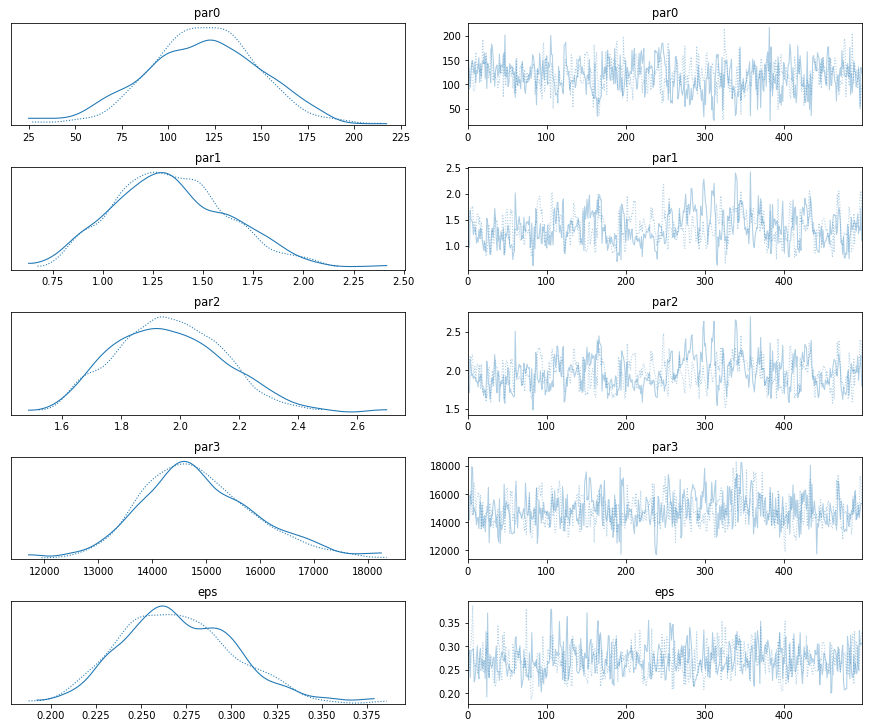

In [4]:
pm.traceplot(trace)
plt.show()

In [5]:
n_lunghezze = 2
day_length = x[-1]-x[-2]
x_in_piu =  np.cumsum(np.ones_like(np.tile(x,(1,n_lunghezze-1)))*day_length)+x[-1]
x_new = np.concatenate([x, x_in_piu])

x_shared.set_value(x_new)
post_pred = pm.sample_posterior_predictive(trace, model=model,samples=1000)

100%|██████████| 1000/1000 [00:02<00:00, 470.45it/s]


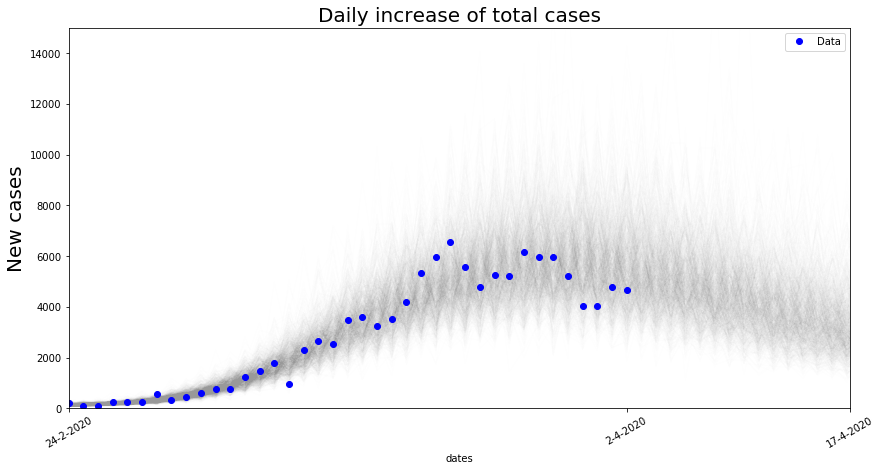

In [6]:
plt.figure(figsize=(14,7))
plt.plot(x_new, post_pred['L_italia'].T, color='0.6', alpha=.002)
plt.plot(x,y, 'o', color='b', label="Data")
plt.ylim(0,15000)

max_x4plot = 4
plt.xlim(min4fit,max_x4plot)
max_date4plot = df.index[-1] + np.timedelta64(int(np.round((max_x4plot-max4fit)/day_length)), 'D')



xticks = [min4fit, max4fit, max_x4plot]
dates2plot = [str(df.index[0].day) + "-" + str(df.index[0].month) + "-" + str(df.index[0].year),
              str(df.index[-1].day) + "-" + str(df.index[-1].month) + "-" + str(df.index[-1].year),
              str(max_date4plot.day) + "-" + str(max_date4plot.month) + "-" + str(max_date4plot.year),
             ]

plt.xticks(xticks, dates2plot, rotation=30)
plt.title("Daily increase of total cases", size=20)
plt.ylabel("New cases", size=20)
plt.xlabel("dates")
plt.legend()
plt.show()

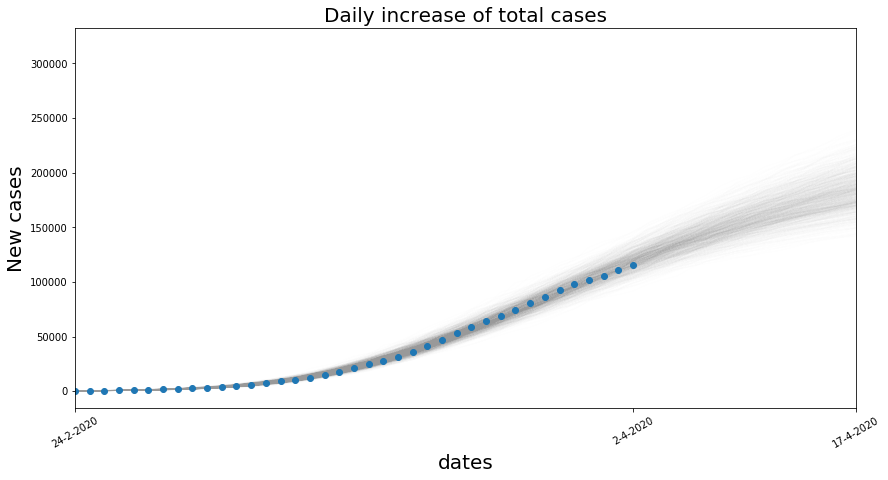

In [7]:
plt.figure(figsize=(14,7))

for data in post_pred['L_italia']:
    plt.plot(x_new, np.cumsum(data), color='0.6', alpha=.002)
    
plt.plot(x, np.cumsum(y), 'o', label='Total cases')
plt.xticks(xticks, dates2plot, rotation=30)
plt.title("Daily increase of total cases", size=20)
plt.ylabel("New cases", size=20)
plt.xlabel("dates", size=20)
plt.xlim(min4fit,max_x4plot)
plt.show()